<a href="https://colab.research.google.com/github/myspip/random_data/blob/master/headline1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

In [0]:
import pandas as pd

In [0]:
train_data = pd.read_csv("https://raw.githubusercontent.com/myspip/random_data/master/Headline/train.csv")[["Good Bad or Neutral","URL of the article"]]
train_data.columns = ["label", 'text']

In [0]:
test_data = pd.read_csv("https://raw.githubusercontent.com/myspip/random_data/master/Headline/test.csv")[["Good Bad or Neutral","URL of the article"]]
test_data.columns = ["label", 'text']

In [7]:
combined_data = pd.concat([train_data, test_data], axis = 0)
combined_data.head()

,label,text
0,Bad,Ford Motor: That's a Lot of Recalls -- Barron'...
1,Neutral,"Press Release: Event Alert: Kinaxis Customer, ..."
2,Bad,Ford Motor: How Risky is Its Autonomous Drivin...
3,Good,Ford Motor Plans Ride-Hailing Service With Fle...
4,Bad,Ford Motor Files 8K - Other Events >F


**Explore data**

In [8]:
data = TextClasDataBunch.from_df(path=".", train_df = train_data, valid_df = test_data)
data.show_batch()

text,target
"xxbos ( xxup files ) xxmaj this file photo taken on xxmaj may 19 , 2016 shows the xxunk of xxmaj germany 's biggest lender xxmaj deutsche xxmaj bank seen during the company 's annual shareholders ' meeting in xxmaj frankfurt xxunk xxmaj main , western xxmaj germany . xxmaj deutsche xxmaj bank , xxmaj germany 's biggest bank , has xxunk to pay $ 95 million to settle a",Bad
"xxbos xxmaj president not a threat to xxmaj fed 's independence , xxmaj mnuchin says ; xxup news xxup briefing ; xxmaj staff and news services ; xxmaj police take xxunk in xxup la xxmaj trader xxmaj xxunk 's into xxunk ; xxmaj french investigators raid home of xxmaj macron 's former bodyguard ; xxmaj fiat xxmaj chrysler chooses xxmaj jeep exec xxmaj manley to replace ill xxup ceo ;",Bad
"xxbos xxmaj trump not threatening xxmaj fed 's independence , xxmaj mnuchin says ; xxup news xxup briefing ; xxmaj staff and news services ; xxmaj trump finds it ' inconceivable ' lawyer would record a client ; xxmaj french investigators raid home of xxmaj macron 's former bodyguard ; xxmaj fiat xxmaj chrysler chooses xxmaj jeep exec xxmaj manley to replace ill xxup ceo ; xxmaj cemetery bodies still",Bad
xxbos * xxmaj the xxmaj walt xxmaj disney xxmaj company xxmaj announces an xxmaj increase in xxmaj its xxmaj interest in xxmaj euro xxmaj disney ; xxmaj its xxmaj xxunk to xxmaj launch a xxmaj tender xxmaj offer for xxmaj all xxmaj xxunk xxmaj euro xxmaj disney xxmaj shares and a xxmaj mandatory xxmaj buy - xxmaj out if the 95 % xxmaj xxunk xxmaj is xxmaj xxunk ; xxmaj,Good
"xxbos xxup nvidia xxup gets xxup into xxup daimler xxup 's xxup self - xxup driving xxup car xxup plans ; xxup xxunk xxup to xxup provide xxup platform xxup for xxup processing xxup xxunk xxup data xxup new xxup partnership xxup to xxup provide xxup platform xxup for xxup self - xxup driving xxup car xxup xxunk xxup for xxup german xxup auto xxup giant , xxup and xxup",Good


In [9]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'to']

In [10]:
data.train_ds[0][0]

Text xxbos xxmaj ford xxmaj motor : xxmaj that 's a xxmaj xxunk of xxmaj recalls -- xxmaj barron 's xxmaj blog

In [11]:
data.train_ds[0][0].data[:10]

array([  2,   5,  31,   5,  27,  11,   5, 239,  15,  28])

**Develop language model**

In [0]:
data_lm = (TextList.from_df(path=".", df = combined_data[['text']])
            .split_by_rand_pct(0.3)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=48))
data_lm.save('data_lm.pkl')

In [0]:
# Load
data_lm = load_data(".", 'data_lm.pkl', bs=48)

In [14]:
data_lm.show_batch()

idx,text
0,xxmaj files 8 k - xxmaj other xxmaj events > f xxbos xxmaj ford xxmaj motor : xxmaj why xxmaj goldman xxmaj sachs xxmaj xxunk in the xxmaj xxunk -- xxmaj barron 's xxmaj blog xxbos xxmaj ford xxmaj motor : xxmaj it 's xxmaj still xxmaj not xxmaj general xxmaj motors -- xxmaj barron 's xxmaj blog xxbos xxmaj ford xxmaj motor xxmaj earnings : xxmaj what to
1,xxbos xxmaj ford xxmaj motor xxmaj files 8 k - xxmaj other xxmaj events > f xxbos xxmaj press xxmaj release : xxmaj ford xxmaj motor xxmaj company xxmaj press xxmaj conference at 2016 xxmaj consumer xxmaj xxunk xxmaj xxunk to xxmaj be xxmaj live - xxmaj xxunk by xxup xxunk xxbos * xxup s&p xxmaj revises xxmaj ford xxmaj motor xxmaj and xxmaj xxunk xxmaj xxunk xxmaj to
2,motor xxmaj company 's 2015 xxmaj annual xxmaj meeting of xxmaj shareholders xxbos xxmaj press xxmaj release : xxmaj ford xxmaj motor xxmaj company xxmaj expands xxmaj xxunk xxmaj xxunk xxmaj xxunk to xxmaj xxunk to xxmaj help xxmaj students xxmaj improve xxmaj xxunk xxmaj xxunk xxmaj xxunk xxbos xxmaj ford xxmaj motor xxmaj files 8 k - xxmaj xxunk xxmaj into xxmaj xxunk xxmaj agreement > f xxbos
3,"street expectations xxbos xxup dj xxmaj exxon xxmaj mobil xxmaj corporation , xxmaj inst xxmaj holders , xxup 2q 2018 ( xxup xom ) xxbos xxmaj press xxmaj release : xxunk xxmaj launches xxmaj new xxmaj exxon xxmaj mobil xxmaj xxunk xxmaj xxunk xxmaj program xxbos xxmaj stocks to xxmaj watch : xxunk , xxmaj xxunk , xxmaj exxon xxmaj mobil , xxmaj xxunk , xxmaj xxunk , xxunk"
4,"california xxunk general probes xxmaj exxon xxmaj mobil over climate change xxbos exxon mobil steps up xxunk ; xxmaj company xxunk for safety , xxunk of xxunk in xxunk at oil refinery xxbos xxmaj new xxmaj york xxunk xxmaj exxon xxmaj mobil in climate case ; xxmaj xxunk are xxunk over xxunk that energy giant did n't xxunk global xxunk risks xxbos xxmaj lower xxup xxunk gas prices xxunk"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


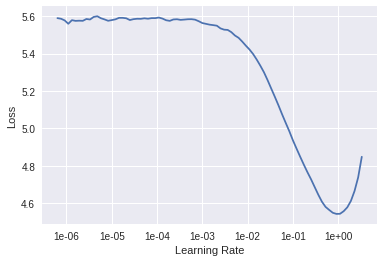

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(3, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.565949,3.227500,0.405804,00:03
1,3.735866,2.947488,0.436384,00:03
2,3.238001,2.906764,0.449330,00:03


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.309796,2.829125,0.460193,00:03
1,2.229812,2.821948,0.462946,00:03


In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "The company runs"
N_WORDS = 20
N_SENTENCES = 2

In [32]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The company runs to back up Apple 's new iphones on March 28 January 2018 , say Apple would
The company runs production at the Indian Project EU Executive Meeting in Europe xxbos Press


In [0]:
learn.save_encoder('fine_tuned_enc')

**Classifier**

In [0]:
# Classifier
data_clas = TextClasDataBunch.from_df(path = ".", train_df = train_data, valid_df = test_data, vocab = data_lm.vocab, text_cols="text", label_cols="label")

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


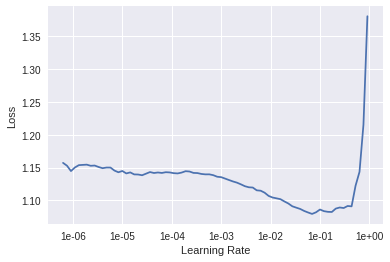

In [40]:
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.044836,1.019004,0.493776,00:02


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [44]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.991636,1.032240,0.489627,00:03


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [47]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(2e-3/(2.6**4),2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.953529,0.997367,0.535270,00:04


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [50]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.927879,0.998461,0.551867,00:05
1,0.910320,0.986432,0.556017,00:06


In [52]:
learn.predict("Company does well")

(Category Bad, tensor(0), tensor([0.4912, 0.2525, 0.2564]))

In [0]:
preds,y = learn.get_preds(ds_type="test", ordered = True)

In [97]:
accuracy(preds,y)

tensor(0.6779)

In [0]:
individual_preds = test_data['text'].apply(learn.predict)

In [98]:
i = 101
print(test_data['text'][i])
print(learn.predict(test_data['text'][i]))
print(individual_preds[i])
print(preds[i])

Gerdau SA to Issue Dividend Increase $0.01 Per Share
(Category Good, tensor(1), tensor([0.1978, 0.5382, 0.2639]))
(Category Good, tensor(1), tensor([0.1978, 0.5382, 0.2639]))
tensor([0.3825, 0.5606, 0.0569])


In [102]:
test_data.label[0:10]

0       Good
1       Good
2       Good
3       Good
4       Good
5       Good
6        Bad
7    Neutral
8        Bad
9       Good
Name: label, dtype: object

In [104]:
y[0:10]

tensor([0, 2, 0, 1, 0, 0, 0, 0, 2, 2])

In [0]:
bad_pred = []
good_pred = []
neutral_pred = []

for idx in range(test_data.shape[0]):
  bad_pred.append(np.array(individual_preds[idx][2][0]).item())
  good_pred.append(np.array(individual_preds[idx][2][1]).item())
  neutral_pred.append(np.array(individual_preds[idx][2][2]).item())



In [0]:
test_data['bad'] = bad_pred
test_data['good'] = good_pred
test_data['neutral'] = neutral_pred

In [0]:
from google.colab import files

test_data.to_csv('scored_test_data.csv')
files.download('scored_test_data.csv')